In [54]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from dataset import create_penn_tree_bank_dataset, tokenizer


In [55]:
# Hyper parameters
DATA_DIR  = './data/PTB'
BATCH_SIZE = 64
BPTT = 20 # backpropagation through time defines sentence length
LEARNING_RATE = 5
MIN_LEARNING_RATE = LEARNING_RATE/10 # minimum learning rate for the scheduler
MAX_GRAD_NORM = 2
WEIGHT_DECAY = 1e-5
EMBEDDING_DIM = 200
HIDDEN_DIM = 200
N_LAYERS = 2 # number of layers in the RNN
DROPOUT = 0.5 # dropout rate (if used)
MAX_EPOCHS = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Section 1: Load and Preprocess the Penn Tree Bank Dataset

In this section, we will load the Penn Tree Bank (PTB) dataset and preprocess it by tokenizing and building a vocabulary.

In [56]:
train_data, valid_data, test_data, vocab = create_penn_tree_bank_dataset(DATA_DIR, BATCH_SIZE, device)

In [57]:
# Plotting some example sentences and their tokenization
def plot_example_sentences(data, vocab, tokenizer, num_sentences=2, sentence_length=20):
    sentences = []
    data = data[:sentence_length,:num_sentences].T.cpu().numpy()
    for i in range(num_sentences):
        sentence = ' '.join([vocab.get_itos()[token] for token in data[i] if vocab.get_itos()[token] not in ['<pad>'] ])
        sentences.append(sentence)
    for i, sentence in enumerate(sentences):
        tokens = tokenizer(sentence)
        print(f"Sentence {i+1}: {sentence}")
        print(f"Tokens: {tokens}\n")

print("Example sentences:")
plot_example_sentences(train_data, vocab, tokenizer)

Example sentences:
Sentence 1: <sos> aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens
Tokens: ['<sos>', 'aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman', 'hydro-quebec', 'ipo', 'kia', 'memotec', 'mlx', 'nahb', 'punts', 'rake', 'regatta', 'rubens']

Sentence 2: the philippines and <unk> <eos> <sos> in addition the u . s . this year offered its own plan for
Tokens: ['the', 'philippines', 'and', '<unk>', '<eos>', '<sos>', 'in', 'addition', 'the', 'u', '.', 's', '.', 'this', 'year', 'offered', 'its', 'own', 'plan', 'for']



## Section 2: Define the RNN Model

We define our RNN model which can be either an LSTM or GRU based on the selected model type.


In [58]:
AVAILABLE_MODELS = ['LSTM_with_dropout', 'LSTM_without_dropout', 'GRU_with_dropout', 'GRU_without_dropout']

SELECTED_MODEL = 'LSTM_without_dropout' # 'LSTM_with_dropout' or 'LSTM_without_dropout' or 'GRU_with_dropout' or 'GRU_without_dropout'
SELECTED_CHECKPOINT = '' # Leave empty if you want to train from scratch

In [59]:
from models.RNN import RNNModel
from trainer import Trainer

assert SELECTED_MODEL in AVAILABLE_MODELS, f"Selected model not available. Please select one of the following: {AVAILABLE_MODELS}"
input_dim = len(vocab)
dropout = 0 if SELECTED_MODEL in ['LSTM_without_dropout', 'GRU_without_dropout'] else DROPOUT
model_type = 'LSTM' if 'LSTM' in SELECTED_MODEL else 'GRU'

model = RNNModel(input_dim, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, device,dropout, model_type=model_type, checkpoint=SELECTED_CHECKPOINT)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=MAX_EPOCHS, eta_min=MIN_LEARNING_RATE)


trainer = Trainer(optimizer, criterion, BPTT, BATCH_SIZE, MAX_EPOCHS, SELECTED_MODEL, MAX_GRAD_NORM)
print(model)
print(optimizer)

RNNModel(
  (embedding): Embedding(9924, 200)
  (rnn): LSTM(200, 200, num_layers=2, dropout=0.5)
  (fc): Linear(in_features=200, out_features=9924, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    initial_lr: 5
    lr: 5
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 1e-05
)


## Section 3: Training

Run these sections to train the created model.


In [60]:
[train_perplexities, valid_perplexities] = trainer.train_model(model, train_data, valid_data)
test_loss, test_perplexity = trainer.evaluate(model, test_data)
print(f'Test Loss: {test_loss:.3f}, Test Perplexity: {test_perplexity:.3f}')

Training Progress:   0%|          | 0/50 [00:05<?, ?it/s]

Epoch: 01, Train Loss: 5.932, Valid Loss: 5.401, Train Perplexity: 376.808, Valid Perplexity: 221.713


Training Progress:   4%|▍         | 2/50 [00:12<04:49,  6.02s/it]

Epoch: 02, Train Loss: 5.448, Valid Loss: 5.187, Train Perplexity: 232.290, Valid Perplexity: 178.968


Training Progress:   6%|▌         | 3/50 [00:18<04:50,  6.17s/it]

Epoch: 03, Train Loss: 5.294, Valid Loss: 5.070, Train Perplexity: 199.102, Valid Perplexity: 159.249


Training Progress:   8%|▊         | 4/50 [00:24<04:49,  6.30s/it]

Epoch: 04, Train Loss: 5.200, Valid Loss: 4.995, Train Perplexity: 181.260, Valid Perplexity: 147.607


Training Progress:  10%|█         | 5/50 [00:31<04:49,  6.44s/it]

Epoch: 05, Train Loss: 5.132, Valid Loss: 4.942, Train Perplexity: 169.438, Valid Perplexity: 140.034


Training Progress:  12%|█▏        | 6/50 [00:38<04:46,  6.52s/it]

Epoch: 06, Train Loss: 5.078, Valid Loss: 4.896, Train Perplexity: 160.521, Valid Perplexity: 133.785


Training Progress:  14%|█▍        | 7/50 [00:44<04:42,  6.57s/it]

Epoch: 07, Train Loss: 5.035, Valid Loss: 4.862, Train Perplexity: 153.736, Valid Perplexity: 129.223


Training Progress:  16%|█▌        | 8/50 [00:51<04:37,  6.61s/it]

Epoch: 08, Train Loss: 4.997, Valid Loss: 4.835, Train Perplexity: 147.962, Valid Perplexity: 125.878


Training Progress:  18%|█▊        | 9/50 [00:58<04:31,  6.63s/it]

Epoch: 09, Train Loss: 4.963, Valid Loss: 4.802, Train Perplexity: 143.039, Valid Perplexity: 121.789


Training Progress:  20%|██        | 10/50 [01:05<04:25,  6.65s/it]

Epoch: 10, Train Loss: 4.934, Valid Loss: 4.788, Train Perplexity: 138.881, Valid Perplexity: 120.030


Training Progress:  22%|██▏       | 11/50 [01:11<04:19,  6.66s/it]

Epoch: 11, Train Loss: 4.906, Valid Loss: 4.761, Train Perplexity: 135.163, Valid Perplexity: 116.897


Training Progress:  24%|██▍       | 12/50 [01:18<04:13,  6.66s/it]

Epoch: 12, Train Loss: 4.882, Valid Loss: 4.749, Train Perplexity: 131.924, Valid Perplexity: 115.425


Training Progress:  26%|██▌       | 13/50 [01:25<04:06,  6.67s/it]

Epoch: 13, Train Loss: 4.859, Valid Loss: 4.723, Train Perplexity: 128.834, Valid Perplexity: 112.515


Training Progress:  28%|██▊       | 14/50 [01:31<04:00,  6.67s/it]

Epoch: 14, Train Loss: 4.837, Valid Loss: 4.711, Train Perplexity: 126.062, Valid Perplexity: 111.156


Training Progress:  30%|███       | 15/50 [01:38<03:53,  6.68s/it]

Epoch: 15, Train Loss: 4.817, Valid Loss: 4.691, Train Perplexity: 123.640, Valid Perplexity: 108.946


Training Progress:  32%|███▏      | 16/50 [01:45<03:47,  6.68s/it]

Epoch: 16, Train Loss: 4.797, Valid Loss: 4.683, Train Perplexity: 121.164, Valid Perplexity: 108.090


Training Progress:  34%|███▍      | 17/50 [01:51<03:40,  6.68s/it]

Epoch: 17, Train Loss: 4.779, Valid Loss: 4.676, Train Perplexity: 119.032, Valid Perplexity: 107.319


Training Progress:  34%|███▍      | 17/50 [01:58<03:40,  6.68s/it]

Epoch: 18, Train Loss: 4.762, Valid Loss: 4.660, Train Perplexity: 116.968, Valid Perplexity: 105.672


Training Progress:  38%|███▊      | 19/50 [02:05<03:29,  6.75s/it]

Epoch: 19, Train Loss: 4.746, Valid Loss: 4.646, Train Perplexity: 115.138, Valid Perplexity: 104.139


Training Progress:  40%|████      | 20/50 [02:12<03:22,  6.73s/it]

Epoch: 20, Train Loss: 4.730, Valid Loss: 4.639, Train Perplexity: 113.240, Valid Perplexity: 103.471


Training Progress:  42%|████▏     | 21/50 [02:18<03:14,  6.72s/it]

Epoch: 21, Train Loss: 4.714, Valid Loss: 4.625, Train Perplexity: 111.464, Valid Perplexity: 102.045


Training Progress:  44%|████▍     | 22/50 [02:25<03:07,  6.71s/it]

Epoch: 22, Train Loss: 4.699, Valid Loss: 4.621, Train Perplexity: 109.867, Valid Perplexity: 101.560


Training Progress:  46%|████▌     | 23/50 [02:32<03:00,  6.70s/it]

Epoch: 23, Train Loss: 4.685, Valid Loss: 4.611, Train Perplexity: 108.287, Valid Perplexity: 100.607


Training Progress:  48%|████▊     | 24/50 [02:38<02:54,  6.70s/it]

Epoch: 24, Train Loss: 4.671, Valid Loss: 4.598, Train Perplexity: 106.828, Valid Perplexity: 99.242


Training Progress:  50%|█████     | 25/50 [02:45<02:47,  6.69s/it]

Epoch: 25, Train Loss: 4.658, Valid Loss: 4.588, Train Perplexity: 105.375, Valid Perplexity: 98.300


Training Progress:  52%|█████▏    | 26/50 [02:52<02:40,  6.69s/it]

Epoch: 26, Train Loss: 4.644, Valid Loss: 4.579, Train Perplexity: 103.972, Valid Perplexity: 97.430


Training Progress:  54%|█████▍    | 27/50 [02:58<02:33,  6.69s/it]

Epoch: 27, Train Loss: 4.632, Valid Loss: 4.564, Train Perplexity: 102.742, Valid Perplexity: 95.931


Training Progress:  56%|█████▌    | 28/50 [03:05<02:27,  6.69s/it]

Epoch: 28, Train Loss: 4.620, Valid Loss: 4.555, Train Perplexity: 101.460, Valid Perplexity: 95.095


Training Progress:  58%|█████▊    | 29/50 [03:12<02:20,  6.69s/it]

Epoch: 29, Train Loss: 4.605, Valid Loss: 4.545, Train Perplexity: 99.962, Valid Perplexity: 94.127


Training Progress:  60%|██████    | 30/50 [03:19<02:13,  6.69s/it]

Epoch: 30, Train Loss: 4.593, Valid Loss: 4.535, Train Perplexity: 98.765, Valid Perplexity: 93.207


Training Progress:  62%|██████▏   | 31/50 [03:25<02:07,  6.69s/it]

Epoch: 31, Train Loss: 4.582, Valid Loss: 4.532, Train Perplexity: 97.700, Valid Perplexity: 92.917


Training Progress:  64%|██████▍   | 32/50 [03:32<02:00,  6.69s/it]

Epoch: 32, Train Loss: 4.571, Valid Loss: 4.522, Train Perplexity: 96.654, Valid Perplexity: 92.062


Training Progress:  66%|██████▌   | 33/50 [03:39<01:53,  6.67s/it]

Epoch: 33, Train Loss: 4.560, Valid Loss: 4.518, Train Perplexity: 95.548, Valid Perplexity: 91.610


Training Progress:  68%|██████▊   | 34/50 [03:45<01:46,  6.68s/it]

Epoch: 34, Train Loss: 4.548, Valid Loss: 4.506, Train Perplexity: 94.451, Valid Perplexity: 90.553


Training Progress:  70%|███████   | 35/50 [03:52<01:40,  6.68s/it]

Epoch: 35, Train Loss: 4.538, Valid Loss: 4.493, Train Perplexity: 93.546, Valid Perplexity: 89.404


Training Progress:  72%|███████▏  | 36/50 [03:58<01:32,  6.63s/it]

Epoch: 36, Train Loss: 4.527, Valid Loss: 4.497, Train Perplexity: 92.521, Valid Perplexity: 89.715


Training Progress:  74%|███████▍  | 37/50 [04:05<01:26,  6.65s/it]

Epoch: 37, Train Loss: 4.516, Valid Loss: 4.486, Train Perplexity: 91.503, Valid Perplexity: 88.788


Training Progress:  76%|███████▌  | 38/50 [04:12<01:19,  6.66s/it]

Epoch: 38, Train Loss: 4.507, Valid Loss: 4.479, Train Perplexity: 90.667, Valid Perplexity: 88.159


Training Progress:  78%|███████▊  | 39/50 [04:19<01:13,  6.67s/it]

Epoch: 39, Train Loss: 4.497, Valid Loss: 4.474, Train Perplexity: 89.791, Valid Perplexity: 87.739


Training Progress:  80%|████████  | 40/50 [04:25<01:06,  6.67s/it]

Epoch: 40, Train Loss: 4.487, Valid Loss: 4.461, Train Perplexity: 88.835, Valid Perplexity: 86.572


Training Progress:  82%|████████▏ | 41/50 [04:32<01:00,  6.68s/it]

Epoch: 41, Train Loss: 4.478, Valid Loss: 4.450, Train Perplexity: 88.033, Valid Perplexity: 85.667


Training Progress:  84%|████████▍ | 42/50 [04:38<00:53,  6.63s/it]

Epoch: 42, Train Loss: 4.469, Valid Loss: 4.451, Train Perplexity: 87.291, Valid Perplexity: 85.712


Training Progress:  84%|████████▍ | 42/50 [04:45<00:53,  6.63s/it]

Epoch: 43, Train Loss: 4.460, Valid Loss: 4.434, Train Perplexity: 86.500, Valid Perplexity: 84.284


Training Progress:  88%|████████▊ | 44/50 [04:53<00:41,  6.92s/it]

Epoch: 44, Train Loss: 4.452, Valid Loss: 4.429, Train Perplexity: 85.773, Valid Perplexity: 83.809


Training Progress:  90%|█████████ | 45/50 [05:00<00:34,  6.85s/it]

Epoch: 45, Train Loss: 4.443, Valid Loss: 4.427, Train Perplexity: 85.006, Valid Perplexity: 83.659


Training Progress:  92%|█████████▏| 46/50 [05:06<00:27,  6.80s/it]

Epoch: 46, Train Loss: 4.434, Valid Loss: 4.424, Train Perplexity: 84.250, Valid Perplexity: 83.445


Training Progress:  94%|█████████▍| 47/50 [05:13<00:20,  6.77s/it]

Epoch: 47, Train Loss: 4.427, Valid Loss: 4.412, Train Perplexity: 83.714, Valid Perplexity: 82.436


Training Progress:  96%|█████████▌| 48/50 [05:20<00:13,  6.68s/it]

Epoch: 48, Train Loss: 4.419, Valid Loss: 4.405, Train Perplexity: 82.998, Valid Perplexity: 81.868


Training Progress:  98%|█████████▊| 49/50 [05:26<00:06,  6.68s/it]

Epoch: 49, Train Loss: 4.411, Valid Loss: 4.403, Train Perplexity: 82.376, Valid Perplexity: 81.713


Training Progress: 100%|██████████| 50/50 [05:33<00:00,  6.67s/it]


Epoch: 50, Train Loss: 4.403, Valid Loss: 4.395, Train Perplexity: 81.711, Valid Perplexity: 81.020
Test Loss: 4.357, Test Perplexity: 78.050


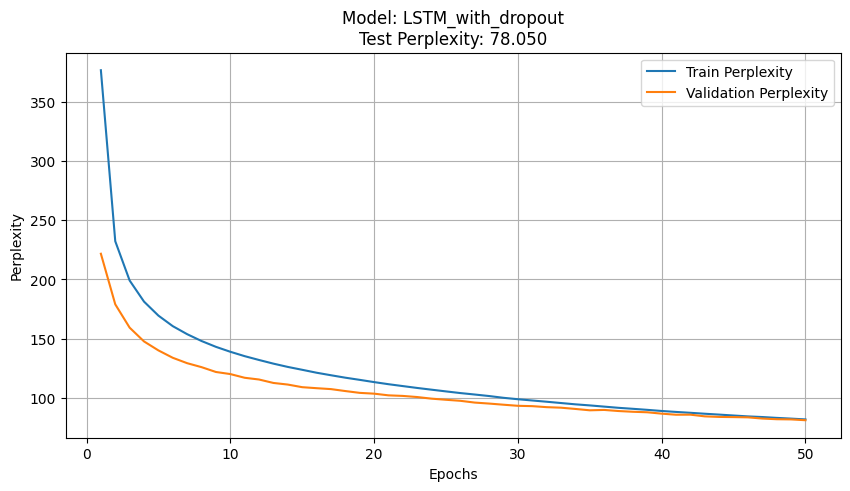

In [61]:
import matplotlib.pyplot as plt

def plot_perplexities(train_perplexities, valid_perplexities, model_type, test_perplexity):
    epochs = range(1, len(train_perplexities) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_perplexities, label='Train Perplexity')
    plt.plot(epochs, valid_perplexities, label='Validation Perplexity')
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.title(f'Model: {model_type}\nTest Perplexity: {test_perplexity:.3f}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the perplexities
plot_perplexities(train_perplexities, valid_perplexities, SELECTED_MODEL, test_perplexity)


## Section 4: Evaluation

Run these sections to evaluated the trained/loaded model.

In [62]:
test_loss, test_perplexity = trainer.evaluate(model, test_data)
print(f'Test Loss: {test_loss:.3f}, Test Perplexity: {test_perplexity:.3f}')

Test Loss: 4.357, Test Perplexity: 78.050


### Sentence completion example

Change here the `start_text` to test senctence completion.

In [63]:
start_text = "The capital"

In [64]:
def generate_sentence(model, vocab, tokenizer, text, max_length=50):
    model.eval()
    tokens = tokenizer('<sos> '+ text)
    input = torch.tensor([vocab[token] for token in tokens if token in vocab.get_stoi()], dtype=torch.long).unsqueeze(1).to(device)
    with torch.no_grad():
        for _ in range(max_length):
            output, _ = model(input)
            next_token = output.argmax(2)[-1, :].item()
            next_token_str = vocab.get_itos()[next_token]
            if next_token_str == '<eos>' or next_token_str == '<unk>':
                break
            input = torch.cat([input, torch.tensor([[next_token]], dtype=torch.long).to(device)], dim=0)
    sentence = ' '.join([vocab.get_itos()[token] for token in input[1:].squeeze().tolist()])
    return sentence


generated_sentence = generate_sentence(model, vocab, tokenizer, start_text)
print(f"Start sentence: {start_text}")
print(f"Generated completion: {generated_sentence}")


Start sentence: The capital
Generated completion: the capital market is
